In [1]:
import numpy as np
import pandas as pd
import pandasql as ps
import math
import itertools 
from scipy import stats
import time


#matplotlib libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors
import seaborn as sns

#date libraries
from dateutil import parser
from datetime import datetime, timedelta, date
import holidays

#prophet library
from prophet import Prophet
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import cross_validation

In [2]:
#pandas options
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#matplotlib setting defaults
sns.set(font="Arial",
        rc={
 "axes.axisbelow": False,
 "axes.edgecolor": "lightgrey",
 "axes.facecolor": "None",
 "axes.grid": False,
 "axes.labelcolor": "dimgrey",
 "axes.spines.right": False,
 "axes.spines.top": False,
 "figure.facecolor": "white",
 "lines.solid_capstyle": "round",
 "patch.edgecolor": "w",
 "patch.force_edgecolor": True,
 "text.color": "dimgrey",
 "xtick.bottom": False,
 "xtick.color": "dimgrey",
 "xtick.direction": "out",
 "xtick.top": False,
 "ytick.color": "dimgrey",
 "ytick.direction": "out",
 "ytick.left": False,
 "ytick.right": False})

In [ ]:
def missing_data(input_data):
    '''
    This function returns dataframe with information about the percentage of nulls in each column and the column data type.
    
    input: pandas df
    output: pandas df
    
    '''
    
    total = input_data.isnull().sum()
    percent = (input_data.isnull().sum()/input_data.isnull().count()*100)
    table = pd.concat([total, percent], axis = 1, keys = ['Total', 'Percent'])
    types = []
    for col in input_data.columns: 
        dtype = str(input_data[col].dtype)
        types.append(dtype)
    table["Types"] = types
    return(pd.DataFrame(table))

def mape(actual, pred): 
    '''
    Mean Absolute Percentage Error (MAPE) Function
    
    input: list/series for actual values and predicted values
    output: mape value 
    '''
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

## READING IN DATA

In [3]:
df = pd.read_csv('DataSets/Real_Estate_Sales.csv')
df.columns = df.columns.str.replace(' ', '_').str.lower()



C:\Users\hp\AppData\Local\Temp\ipykernel_30060\619363330.py:1: DtypeWarning: Columns (8,9,10,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('DataSets/Real_Estate_Sales.csv')


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1054159 entries, 0 to 1054158
Data columns (total 14 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   serial_number     1054159 non-null  int64  
 1   list_year         1054159 non-null  int64  
 2   date_recorded     1054157 non-null  object 
 3   town              1054159 non-null  object 
 4   address           1054108 non-null  object 
 5   assessed_value    1054159 non-null  float64
 6   sale_amount       1054159 non-null  float64
 7   sales_ratio       1054159 non-null  float64
 8   property_type     671713 non-null   object 
 9   residential_type  660275 non-null   object 
 10  non_use_code      302242 non-null   object 
 11  assessor_remarks  161472 non-null   object 
 12  opm_remarks       11564 non-null    object 
 13  location          254643 non-null   object 
dtypes: float64(3), int64(2), object(9)
memory usage: 112.6+ MB


In [5]:
df['date_recorded'] = pd.to_datetime(df['date_recorded'])

In [6]:
min(df['date_recorded']), max(df['date_recorded'])

(Timestamp('1999-04-05 00:00:00'), Timestamp('2022-09-30 00:00:00'))

In [7]:
df.head()

,serial_number,list_year,date_recorded,town,address,assessed_value,sale_amount,sales_ratio,property_type,residential_type,non_use_code,assessor_remarks,opm_remarks,location
0,2020348,2020,2021-09-13,Ansonia,230 WAKELEE AVE,150500.00,325000.00,0.46,Commercial,NaN,NaN,NaN,NaN,NaN
1,20002,2020,2020-10-02,Ashford,390 TURNPIKE RD,253000.00,430000.00,0.59,Residential,Single Family,NaN,NaN,NaN,NaN
2,210317,2021,2022-07-05,Avon,53 COTSWOLD WAY,329730.00,805000.00,0.41,Residential,Single Family,NaN,NaN,NaN,POINT (-72.846365959 41.781677018)
3,200212,2020,2021-03-09,Avon,5 CHESTNUT DRIVE,130400.00,179900.00,0.72,Residential,Condo,NaN,NaN,NaN,NaN
4,200243,2020,2021-04-13,Avon,111 NORTHINGTON DRIVE,619290.00,890000.00,0.70,Residential,Single Family,NaN,NaN,NaN,NaN


In [8]:
from sklearn.impute import SimpleImputer

# Initialize the SimpleImputer with the strategy 'constant'
imputer = SimpleImputer(strategy='most_frequent') #

# Specify the columns with missing values that we want to impute
columns_with_missing_values = ['property_type','residential_type','location','address','opm_remarks','assessor_remarks']

In [9]:
# Apply the imputer to fill missing values with the mean
df[columns_with_missing_values] = imputer.fit_transform(df[columns_with_missing_values])

In [10]:
# Initialize the SimpleImputer with the strategy 'constant'
imputer_c = SimpleImputer(strategy='constant') #

# Specify the columns with missing values that we want to impute
columns_with_missing_values = ['non_use_code']

In [11]:
# Apply the imputer to fill missing values with the mean
df[columns_with_missing_values] = imputer_c.fit_transform(df[columns_with_missing_values])

df.isnull().sum()

serial_number       0
list_year           0
date_recorded       2
town                0
address             0
assessed_value      0
sale_amount         0
sales_ratio         0
property_type       0
residential_type    0
non_use_code        0
assessor_remarks    0
opm_remarks         0
location            0
dtype: int64

In [12]:
# replacing na values in DateRecorded with forward data 
df["date_recorded"].fillna( method ='ffill', inplace = True)

C:\Users\hp\AppData\Local\Temp\ipykernel_30060\3846421536.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["date_recorded"].fillna( method ='ffill', inplace = True)
C:\Users\hp\AppData\Local\Temp\ipykernel_30060\3846421536.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["date_recorded"].fillna( method ='ffill', inplace = True)


Let's aggregate the dataset to the "property_type" and "sale_amount" daily level so that we can have high volume metrics for demand forecasting throughout the country.

In [13]:
agg_df=df.groupby(['date_recorded','property_type']).agg({'sale_amount':'sum'}).reset_index().sort_values(['property_type','date_recorded'])

In [14]:
agg_df.head()

,date_recorded,property_type,sale_amount
18024,2020-10-01,Apartments,1500000.00
18029,2020-10-02,Apartments,151000.00
18036,2020-10-05,Apartments,260000.00
18041,2020-10-06,Apartments,317000.00
18046,2020-10-07,Apartments,826000.00


In [15]:
df.isna().sum()  #Checking for null values

serial_number       0
list_year           0
date_recorded       0
town                0
address             0
assessed_value      0
sale_amount         0
sales_ratio         0
property_type       0
residential_type    0
non_use_code        0
assessor_remarks    0
opm_remarks         0
location            0
dtype: int64

In [16]:
total_sales_df = agg_df.pivot(index='date_recorded',columns='property_type', values='sale_amount')
#total_sales_df.drop('LIQUOR,WINE,BEER',axis='columns',inplace=True)
total_sales_df.head()

property_type,Apartments,Commercial,Condo,Four Family,Industrial,Public Utility,Residential,Single Family,Three Family,Two Family,Vacant Land
date_recorded,,,,,,,,,,,
1999-04-05,NaN,NaN,95000.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-08-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,635000.00,NaN,NaN,NaN
2001-08-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,558000.00,NaN,NaN,NaN
2001-09-04,NaN,NaN,88000.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-09-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,256000.00,NaN,NaN,NaN


In [17]:
mean_value = agg_df['sale_amount'].mean()
mean_value

20705864.374360327

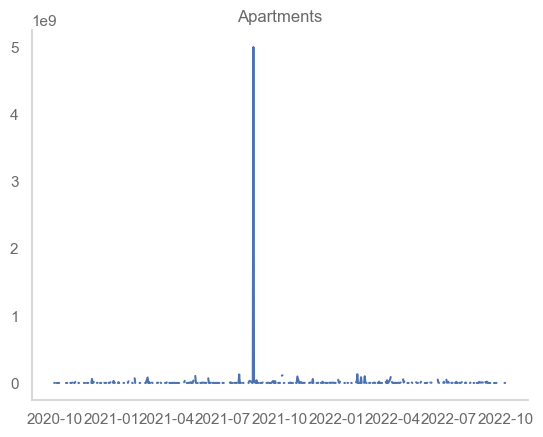

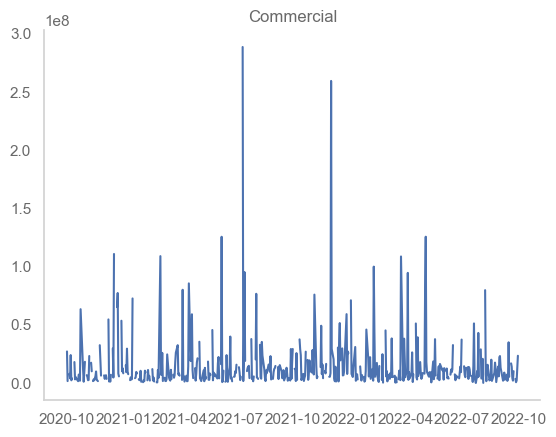

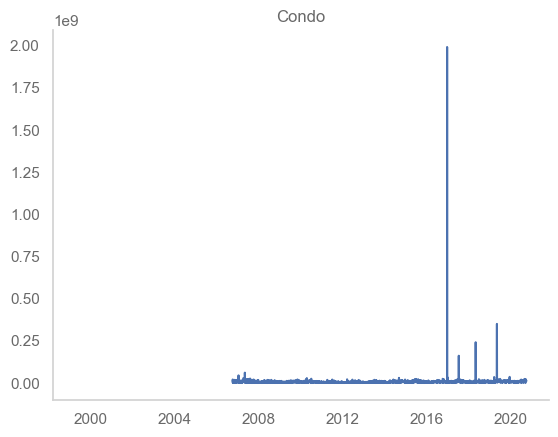

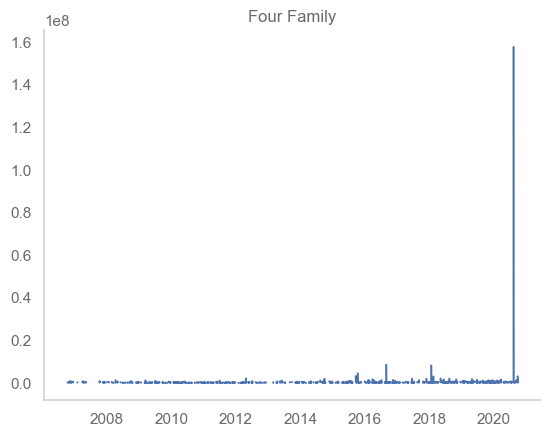

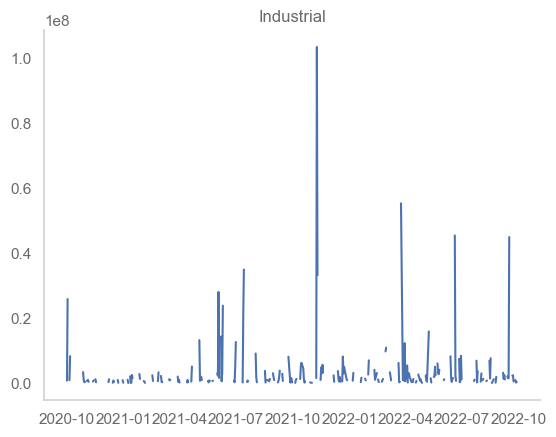

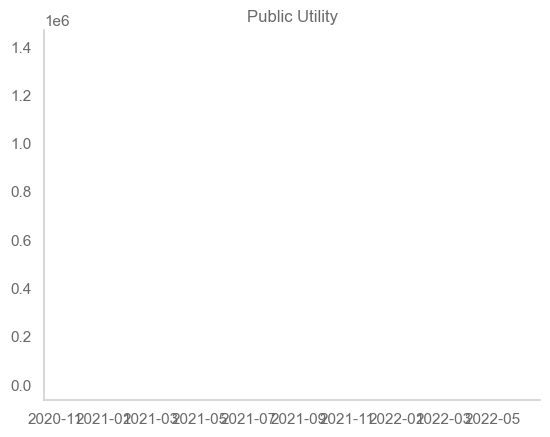

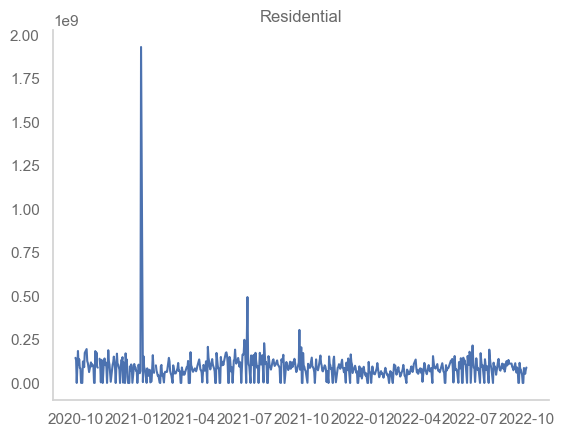

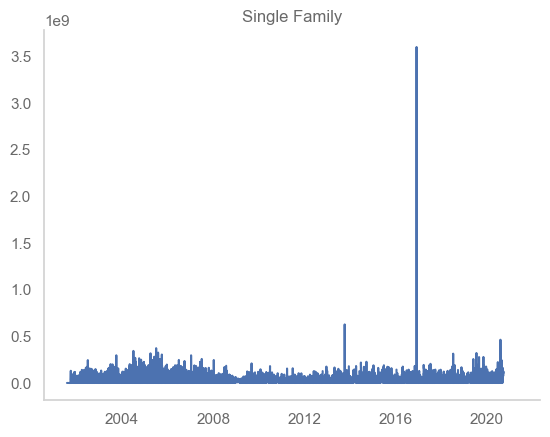

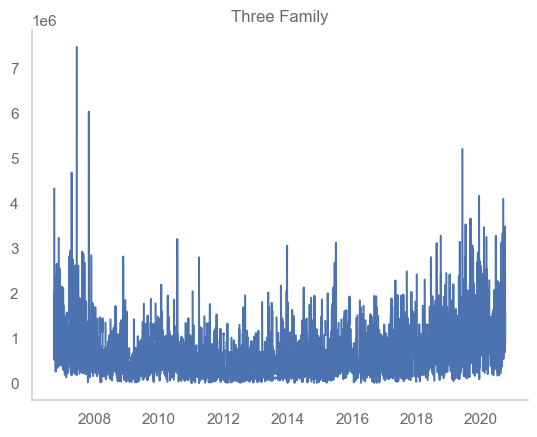

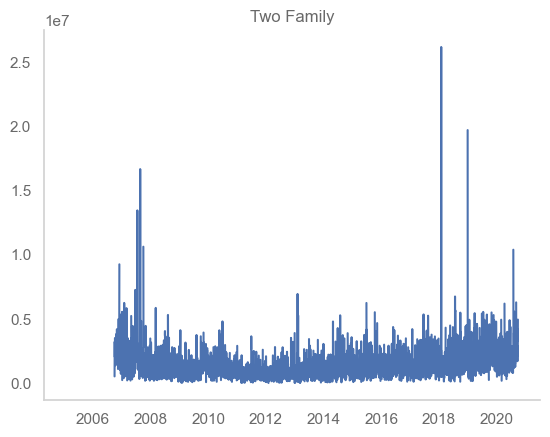

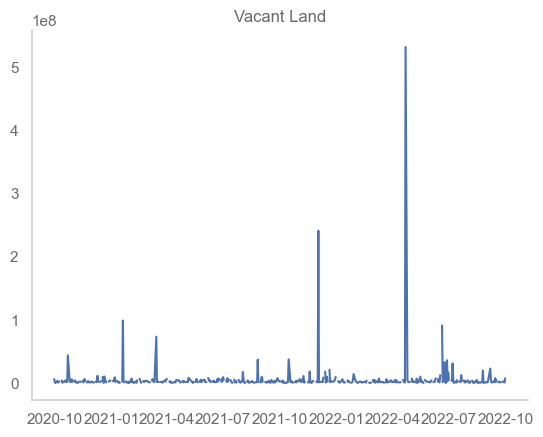

In [18]:
for column in total_sales_df.columns:
    plt.plot(total_sales_df[column])
    plt.title(column)
    plt.show()

### Show missing values 

In [19]:
missing_data(total_sales_df).head()

NameError: name 'missing_data' is not defined

## DATA CLEANING REQUIREMENTS

1. Remove low-volume data that can't be predicted.
2. Remove situations where there's not enough data. (i.e. by visual inspection or by number of '0' daily sales counts.
3. Remove outliers (automated by calculating z-score and just removing it and having Prophet impute those values). This will remove the outliers near 0 for all categories.

In [20]:
old_len = len(total_sales_df.columns)

#Keep categories with avg daily sales greater than $10000
total_sales_df = total_sales_df[total_sales_df.columns[total_sales_df.apply(np.mean,axis='rows') > 10000]]

print("Dropping "+ str(old_len-len(total_sales_df.columns))+" columns due to insufficient data volume.")

Dropping 0 columns due to insufficient data volume.


In [ ]:
#Get percentage of rows for each category that is at 0

(total_sales_df == 0).astype(int).sum(axis=0)/len(total_sales_df.sum(axis=0))

In [ ]:
print(total_sales_df.columns)

In [ ]:
#Need to break out each into it's own dataframe for prediction since each will have different rows affected
prediction_df_list = []

#Cleaning up dataframe using z-score to remove outliers which heavily bias the model
for column in total_sales_df.columns:
    df_clean = total_sales_df[[column]].reset_index()
    
    z = np.abs(stats.zscore(df_clean[column]))
    outlier_index = np.where(z > 2.7)[0] #As 99.7% of the data points lie between 3 standard deviations (Gaussian Distribution)
    print("Dropping "+str(len(outlier_index))+" rows for following category: "+column)
    df_clean.drop(index=outlier_index,inplace=True)
    df_clean.set_index('date_recorded', inplace=True)
    prediction_df_list.append(df_clean)

In [ ]:
for i in range(len(prediction_df_list)):
    plt.plot(prediction_df_list[i])
    plt.title(prediction_df_list[i].columns[0]+'- Average Daily Sales: '+str(prediction_df_list[i].mean()))
    plt.ylim(ymin=0)
    plt.show()

### PLOTTING CATEGORIES

In [ ]:
#lets break it down by thirds for low, mid, high
avg_daily_sales = total_sales_df.apply(np.mean, axis=0).sort_values()
low, mid = np.percentile(total_sales_df.apply(np.mean, axis=0).sort_values(),[33,66])

In [ ]:
low_vol_columns = avg_daily_sales[avg_daily_sales<=low].index.tolist()
mid_vol_columns = avg_daily_sales[(avg_daily_sales>low) & (avg_daily_sales<mid)].index
high_vol_columns = avg_daily_sales[avg_daily_sales>=mid].index

In [ ]:
#total_sales_df[low_vol_columns].plot.line()
plt.plot(total_sales_df[low_vol_columns])
plt.legend(low_vol_columns, loc='best') #, bbox_to_anchor=(1.1, 1.1))
plt.show()

In [ ]:
plt.plot(total_sales_df[mid_vol_columns])
plt.legend(mid_vol_columns, loc='best', bbox_to_anchor=(1.1, 1.1))
plt.xticks(rotation=30)
plt.show()

In [ ]:
plt.plot(total_sales_df[high_vol_columns])
plt.legend(high_vol_columns, loc='best', bbox_to_anchor=(1.1, 1.1))
plt.xticks(rotation=30)
plt.show()

### Adding Holidays

In [ ]:
#adding holiday data

holiday = pd.DataFrame([])

uk_holidays = holidays.GB()  # this is a dict
# the below is the same, but takes a string:
uk_holidays = holidays.country_holidays('GB')  # this is a dict


for date_, name in sorted(holidays.EC(years=[2015,2016,2017,2018,2019,2020,2021,2022]).items()):
    holiday = pd.concat([holiday, pd.DataFrame({'ds': date_, 'holiday': "UK-Holidays", 'lower_window': -2, 'upper_window': 1}, index=[0])], ignore_index=True) 

holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')
holiday.head()

In [ ]:
#Variables

forecast_start_dt = date(2017,7,1) #data set ends of (2017,8,15)
forecast_start_date = (forecast_start_dt).strftime("%Y-%m-%d") 
print(forecast_start_date)

In [ ]:
#setting variables
feature = 'Commercial'
prediction_days = 30

In [ ]:
df = total_sales_df[[feature]].reset_index()
df.tail()

In [ ]:
mean_val = df['Commercial'].mean()
mean_val

In [ ]:
df['Commercial'].fillna(value=mean_val, inplace=True)

In [ ]:
#PROPHET MODEL

df_copy = df.copy()
df_copy = df_copy.rename(columns={'date_recorded': 'ds', feature: 'y'})
df_copy[['y']] = df_copy[['y']].apply(pd.to_numeric)

df_copy['ds'] = pd.to_datetime(df_copy['ds'])

train_set = df_copy[(df_copy['ds'] < forecast_start_date) ]

m = Prophet()

m.fit(train_set)

future = m.make_future_dataframe(periods=prediction_days)
fcst_prophet_train = m.predict(future)

#adding filter to only add the forecasted data into predicted_df
filter = fcst_prophet_train['ds']>=forecast_start_date 
predicted_df = fcst_prophet_train[filter][['ds','yhat']]

In [ ]:
predicted_df.head(10)

In [ ]:
df_copy = df.copy()
df_copy.columns = ['ds', 'ytrue']
predicted_df = predicted_df.merge(df_copy)

In [ ]:
predicted_df

In [ ]:
mape(predicted_df['ytrue'], predicted_df['yhat'])

## Cross Validation with Prophet

Find the "best" parameters by testing over various periods of time with those parameters (cross-validation).

In [ ]:
m = Prophet()
m.fit(train_set)
df_cv = cross_validation(m, initial='730 days', period=30, horizon = 30)

In [ ]:
df_p = performance_metrics(df_cv)
df_p